In [16]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install cvxopt


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3.9 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 9.1 MB/s eta 0:00:0000:0100:01

[

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [4]:
df = pd.read_csv('Datasets/student-performance-dataset.csv')

In [5]:
df.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


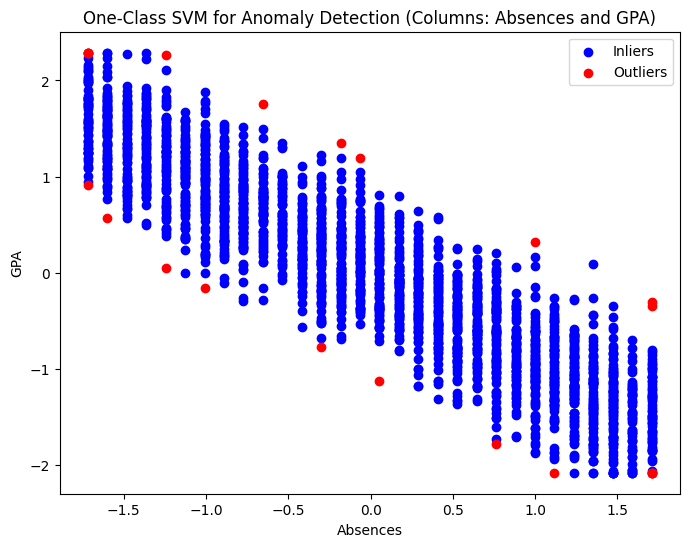

In [6]:
x_column = 'Absences'
y_column = 'GPA'

# Extract the selected columns
data = df[[x_column, y_column]]

# Standardise the data
scaler = StandardScaler()
data_norm = scaler.fit_transform(data)

model = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.7)
model.fit(data_norm)

# Predict anomalies, outliers = -1
y_pred = model.predict(data_norm)

plt.figure(figsize=(8, 6))

# Inliers
plt.scatter(data_norm[y_pred == 1, 0], data_norm[y_pred == 1, 1], color='blue', label='Inliers')

# Outliers
plt.scatter(data_norm[y_pred == -1, 0], data_norm[y_pred == -1, 1], color='red', label='Outliers')

plt.title(f"One-Class SVM for Anomaly Detection (Columns: {x_column} and {y_column})")
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.legend()
plt.show()


In [7]:
cols = ['Absences','GPA']
num_data = df[cols]

# Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_data)

# Apply One-Class SVM
svm_model = OneClassSVM(kernel='rbf', gamma=0.7, nu=0.01)
svm_labels = svm_model.fit_predict(scaled_data)

# Add SVM labels to the original data
df['svm_label'] = svm_labels

# Filter rows considered anomalous
anomalous_data = df[df['svm_label'] == -1]

# Display the anomalous rows
print(anomalous_data)

      StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
115        1116   18       1          0                  3         1.559877   
442        1443   15       0          0                  2        19.424398   
474        1475   17       1          1                  2         1.444587   
484        1485   15       1          0                  3         0.767231   
538        1539   15       1          1                  2         1.447528   
591        1592   18       0          2                  2         7.560499   
947        1948   18       0          1                  1        13.098822   
1105       2106   18       0          2                  2        19.520403   
1249       2250   18       0          3                  1         6.185362   
1303       2304   16       0          0                  1        19.124423   
1327       2328   15       1          0                  1        19.444594   
1500       2501   17       1          1             

In [12]:
class OCSVM:
    def __init__(self, nu=0.1, kernel='rbf', gamma=1.0):
        self.nu = nu
        self.kernel = kernel
        self.gamma = gamma

    def _kernel_function(self, X, Y=None):
        # Computer the kernel matrix
        if Y is None:
            Y = X
        if self.kernel == 'rbf':
            # Radial basis function
            sq_dist = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
            return np.exp(-self.gamma * sq_dist)
        elif self.kernel == 'linear':
            # Linear kernel
            return np.dot(X, Y.T)
        elif self.kernel == 'poly':
            # Polynomial kernel
            return (np.dot(X, Y.T) + 1) ** 3
        else:
            raise ValueError("Unsupported kernel type")

    def fit(self, X):
        n_samples = X.shape[0]
        K = self._kernel_function(X)

        # Define the quadratic programming problem
        P = matrix(K)
        q = matrix(-np.ones((n_samples, 1)))
        
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) / (self.nu * n_samples))))
        
        A = matrix(1.0, (1, n_samples)) # Equaltiy constraint
        b = matrix(1.0)

        # Solve quadratic programming problem
        sol = solvers.qp(P, q, G, h, A, b)

        # Extract Lagrange multipliers (alphas)
        alphas = np.array(sol['x']).flatten()
        support_vector_indices = alphas > 1e-5
        self.alphas = alphas[support_vector_indices]
        self.support_vectors = X[support_vector_indices]
        self.K_sv = K[support_vector_indices][:, support_vector_indices]
        
        # Compute the intercept term
        self.rho = np.mean(self.K_sv @ self.alphas)

    def decision_function(self, X):
        # Compute the decision function
        K_test = self._kernel_function(X, self.support_vectors)
        return np.sum(K_test * self.alphas, axis=1) - self.rho

    def predict(self, X):
        # Predict whether the data is an inlier or an outlier
        return np.sign(self.decision_function(X))
    
    
    def plot(self, X):
        predictions = self.predict(X)
        inliers = X[predictions == 1]
        outliers = X[predictions == -1]

        # Print IDs of outliers
        outlier_ids = np.where(predictions == -1)[0]
        print("Outlier IDs:", outlier_ids)

        plt.figure(figsize=(8, 6))
        plt.scatter(inliers[:, 0], inliers[:, 1], c='blue', label='Inliers', s=20)
        plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers', s=20)
        plt.title('One-Class SVM Results')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.grid(True)
        plt.show()

     pcost       dcost       gap    pres   dres
 0: -9.1864e-01 -1.0119e+02  5e+03  3e+01  2e-16
 1: -9.1130e-01 -9.3548e+01  1e+02  4e-01  3e-16
 2: -8.7684e-01 -7.0146e+00  6e+00  4e-03  4e-16
 3: -8.7652e-01 -1.4521e+00  6e-01  4e-04  6e-16
 4: -8.8704e-01 -1.3312e+00  4e-01  2e-04  3e-16
 5: -8.9647e-01 -1.0684e+00  2e-01  6e-05  1e-16
 6: -8.9852e-01 -1.0621e+00  2e-01  5e-05  1e-16
 7: -9.0414e-01 -1.0241e+00  1e-01  3e-05  9e-17
 8: -9.0600e-01 -9.9607e-01  9e-02  5e-06  8e-17
 9: -9.1320e-01 -9.5309e-01  4e-02  1e-06  8e-17
10: -9.1557e-01 -9.4268e-01  3e-02  3e-07  7e-17
11: -9.1649e-01 -9.3812e-01  2e-02  2e-07  8e-17
12: -9.1817e-01 -9.3097e-01  1e-02  4e-08  7e-17
13: -9.1929e-01 -9.2708e-01  8e-03  2e-08  8e-17
14: -9.2015e-01 -9.2446e-01  4e-03  7e-09  7e-17
15: -9.2081e-01 -9.2231e-01  1e-03  2e-10  8e-17
16: -9.2089e-01 -9.2210e-01  1e-03  1e-10  8e-17
17: -9.2116e-01 -9.2152e-01  4e-04  3e-11  7e-17
18: -9.2122e-01 -9.2140e-01  2e-04  2e-16  9e-17
19: -9.2127e-01 -9.21

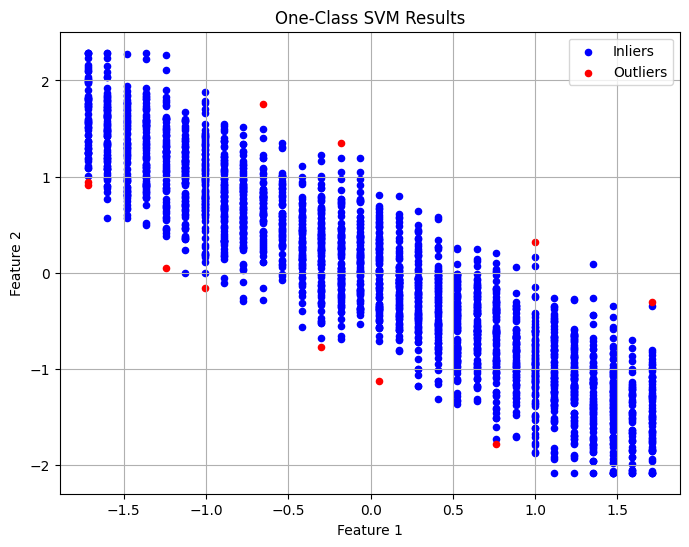

Predictions: [1. 1. 1. ... 1. 1. 1.]


In [13]:
data = df[['Absences', 'GPA']]
data_norm = StandardScaler().fit_transform(data)

# Train custom One-Class SVM
oc_svm = OCSVM(nu=0.01, kernel='rbf', gamma=1)
oc_svm.fit(data_norm)
oc_svm.plot(data_norm)

# Predict on training data_norm
predictions = oc_svm.predict(data_norm)
print("Predictions:", predictions)
